In [5]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp
import matplotlib.pyplot as plt

sys.path.append('..')

from functions.visualization import retinotopic_map_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from functions.evaluation import predicted_vs_empirical, return_list_of_subs, transform_polarangle
from ipywidgets import interact, Dropdown

In [ ]:
path_to_freesurfer = '/BULK/LABDATA/openneuro/ds003787/derivatives/freesurfer/'
subject_id = os.listdir(path_to_freesurfer)
if 'processed' in subject_id:
    subject_id.remove('processed')
subject_id.sort()

prediction = Dropdown(options = ['empirical',
                                 'model'])
retinotopic_map = ['polarAngle', 'eccentricity', 'pRFsize']
binarize = Dropdown(options = [False, True])
hemisphere = Dropdown(options = ['lh', 'rh'])

@interact(subject_id=subject_id, prediction = prediction, 
          binarize = binarize, retinotopic_map = retinotopic_map,
          hemisphere = hemisphere)
def plot1(subject_id,prediction, binarize, retinotopic_map, hemisphere):
    return retinotopic_map_plot(subject_id, path_to_freesurfer, '../templates',
                                 prediction = prediction, binarize = binarize,
                                 retinotopic_map = retinotopic_map, hemisphere = hemisphere, dataset = 'nyu')

interactive(children=(Dropdown(description='subject_id', options=('sub-wlsubj001', 'sub-wlsubj004', 'sub-wlsub…

Region of interest: V1
Threshold: 0.1
0.9389888048171997


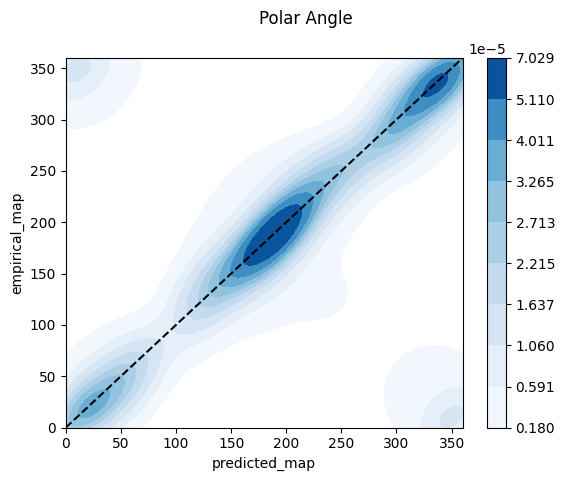

Threshold: 0.1
PearsonRResult(statistic=0.7847407131629983, pvalue=0.0)


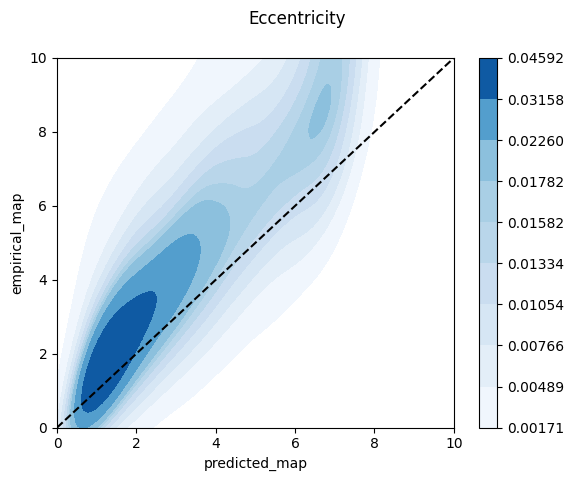

Threshold: 0.1
PearsonRResult(statistic=0.24245158864494645, pvalue=0.0)


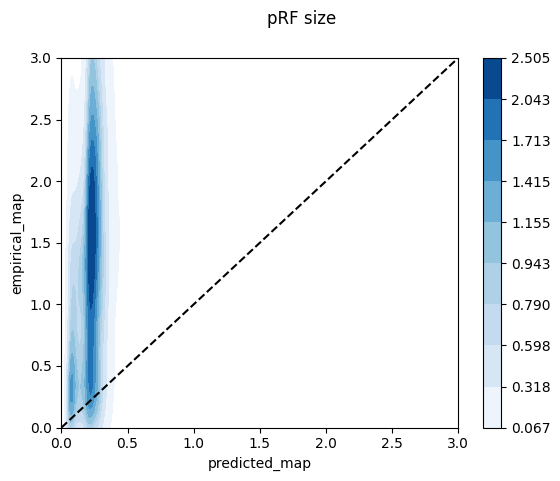

Region of interest: V2
Threshold: 0.1
-0.8949934244155884


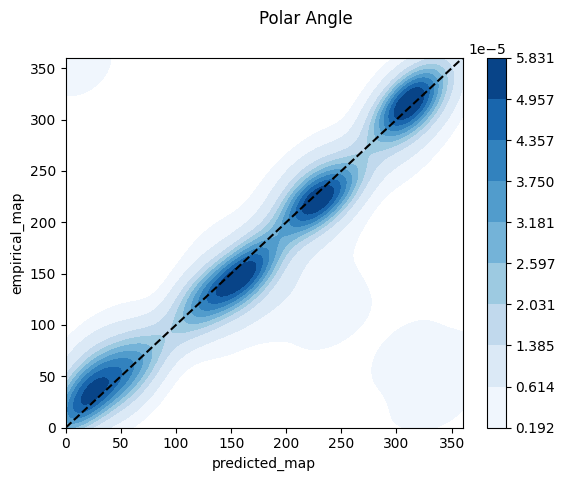

Threshold: 0.1
PearsonRResult(statistic=0.7876723676930836, pvalue=0.0)


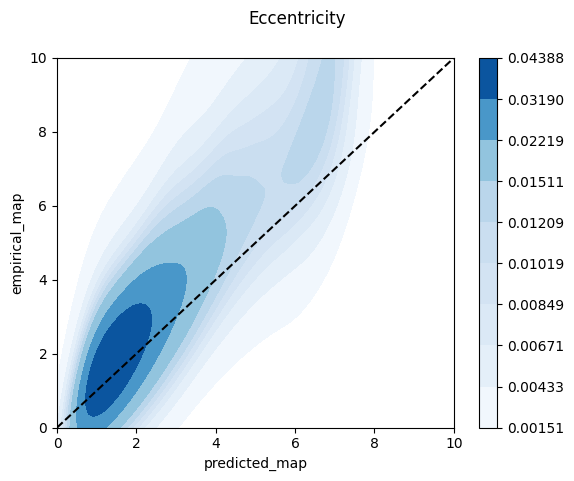

Threshold: 0.1
PearsonRResult(statistic=0.18890302865291864, pvalue=4.306748026325822e-211)


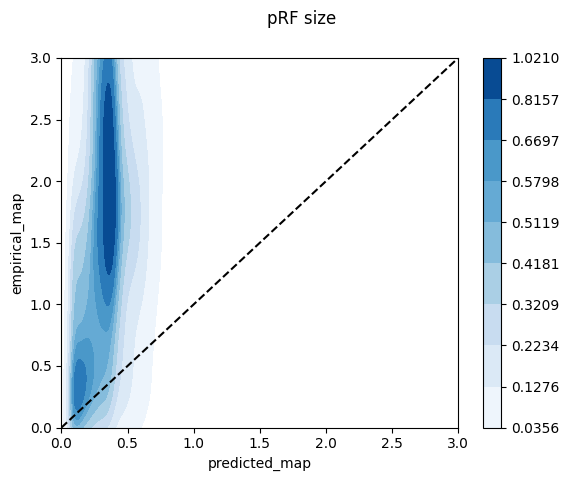

Region of interest: V3
Threshold: 0.1
0.9121588468551636


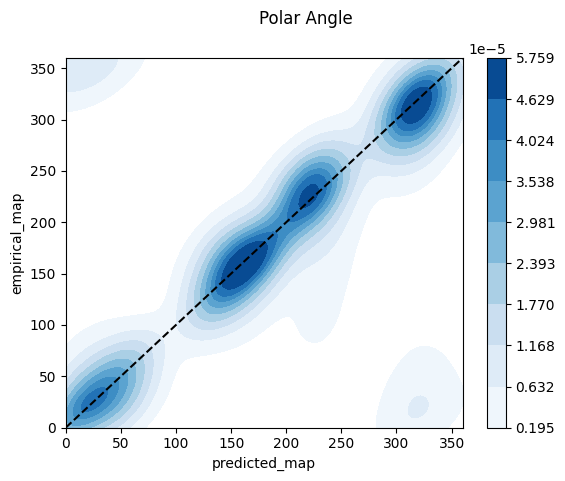

Threshold: 0.1
PearsonRResult(statistic=0.7960083401239864, pvalue=0.0)


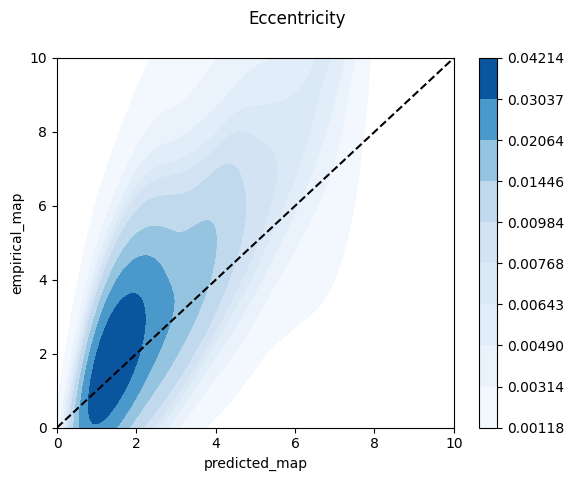

Threshold: 0.1
PearsonRResult(statistic=0.5305370241295417, pvalue=0.0)


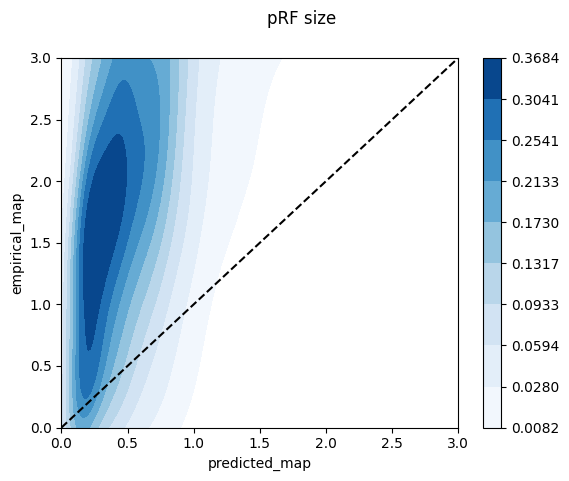

Region of interest: earlyvisualcortex
Threshold: 0.1
0.7889732718467712


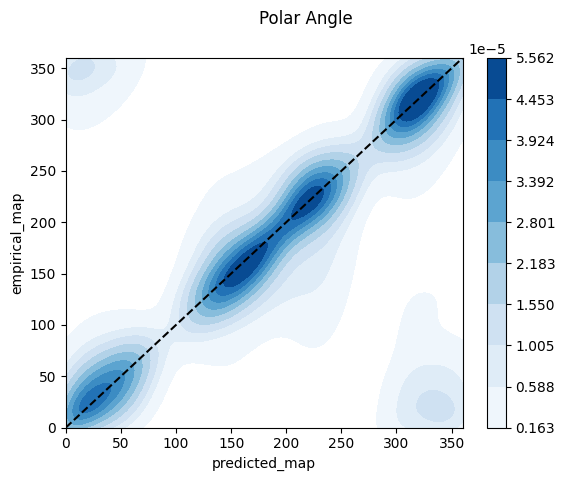

Threshold: 0.1
PearsonRResult(statistic=0.7413771856517987, pvalue=0.0)


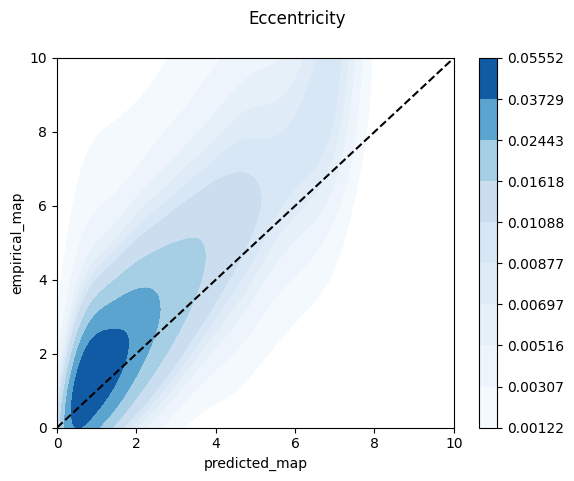

Threshold: 0.1
PearsonRResult(statistic=0.6745025606347748, pvalue=0.0)


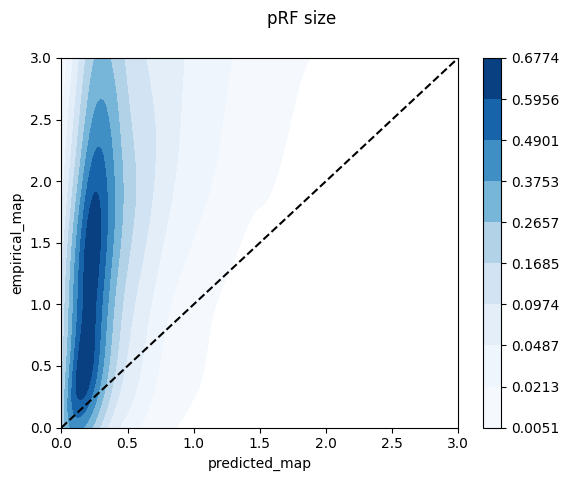

Region of interest: all
Threshold: 0.1
0.672481894493103


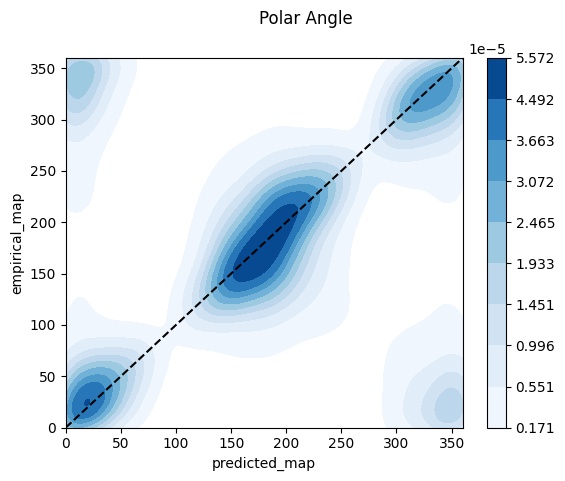

Threshold: 0.1
PearsonRResult(statistic=0.539173938669537, pvalue=0.0)


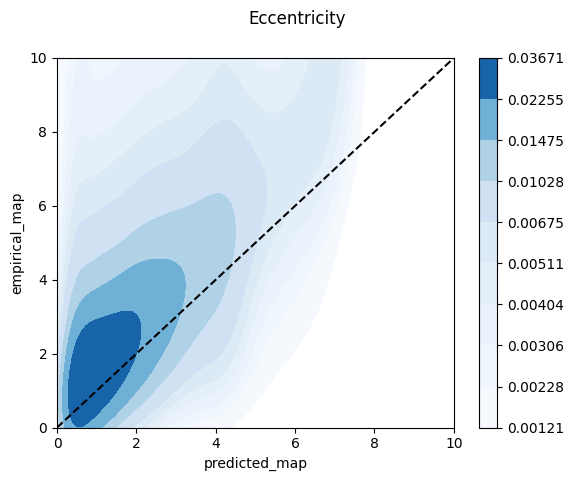

Threshold: 0.1
PearsonRResult(statistic=0.5584123168517787, pvalue=0.0)


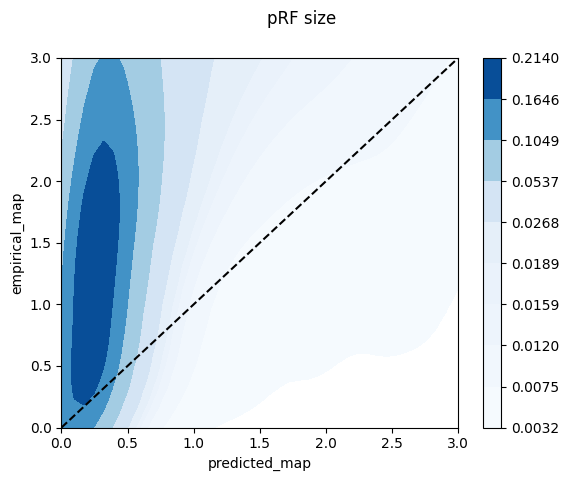

In [ ]:
dataset_name = 'nyu'
path = '/BULK/LABDATA/openneuro/ds003787/derivatives/freesurfer'
retinotopic_maps = ['polarAngle', 'eccentricity', 'pRFsize']

for hemispheres in ['both']:
    for threshold in [0.1]:
        for roi in ['V1', 'V2', 'V3', 'earlyvisualcortex', 'all']:
            predicted_vs_empirical(path, dataset_name, retinotopic_maps, hemispheres = hemispheres, threshold=threshold, region_of_interest=roi)